<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Gender-Analysis" data-toc-modified-id="Gender-Analysis-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Gender Analysis</a></span><ul class="toc-item"><li><span><a href="#Computing-Gender-Screen-Time" data-toc-modified-id="Computing-Gender-Screen-Time-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Computing Gender Screen Time</a></span></li><li><span><a href="#Gender-Screen-Time-in-Our-Dataset" data-toc-modified-id="Gender-Screen-Time-in-Our-Dataset-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Gender Screen Time in Our Dataset</a></span></li><li><span><a href="#Changes-in-gender-representation-over-time" data-toc-modified-id="Changes-in-gender-representation-over-time-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Changes in gender representation over time</a></span></li><li><span><a href="#Gender-Representation-by-Genre" data-toc-modified-id="Gender-Representation-by-Genre-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Gender Representation by Genre</a></span></li><li><span><a href="#Distribution-of-movies-by-year" data-toc-modified-id="Distribution-of-movies-by-year-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Distribution of movies by year</a></span></li><li><span><a href="#Shot-Duration" data-toc-modified-id="Shot-Duration-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Shot Duration</a></span><ul class="toc-item"><li><span><a href="#Average-Shot-Duration-Over-the-Years" data-toc-modified-id="Average-Shot-Duration-Over-the-Years-1.6.1"><span class="toc-item-num">1.6.1&nbsp;&nbsp;</span>Average Shot Duration Over the Years</a></span></li><li><span><a href="#Changes-in-Shot-Duration-Within-Movies-(Narrative-Structure)" data-toc-modified-id="Changes-in-Shot-Duration-Within-Movies-(Narrative-Structure)-1.6.2"><span class="toc-item-num">1.6.2&nbsp;&nbsp;</span>Changes in Shot Duration Within Movies (Narrative Structure)</a></span></li></ul></li><li><span><a href="#Shot-Scale" data-toc-modified-id="Shot-Scale-1.7"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>Shot Scale</a></span><ul class="toc-item"><li><span><a href="#Changes-in-shot-scale-over-time" data-toc-modified-id="Changes-in-shot-scale-over-time-1.7.1"><span class="toc-item-num">1.7.1&nbsp;&nbsp;</span>Changes in shot scale over time</a></span></li><li><span><a href="#More-Changes-in-Shot-Scale-over-time" data-toc-modified-id="More-Changes-in-Shot-Scale-over-time-1.7.2"><span class="toc-item-num">1.7.2&nbsp;&nbsp;</span>More Changes in Shot Scale over time</a></span></li><li><span><a href="#Relationship-between-shot-duration-and-shot-scale" data-toc-modified-id="Relationship-between-shot-duration-and-shot-scale-1.7.3"><span class="toc-item-num">1.7.3&nbsp;&nbsp;</span>Relationship between shot duration and shot scale</a></span></li></ul></li><li><span><a href="#Brightness" data-toc-modified-id="Brightness-1.8"><span class="toc-item-num">1.8&nbsp;&nbsp;</span>Brightness</a></span><ul class="toc-item"><li><span><a href="#Changes-in-brightness-over-the-years" data-toc-modified-id="Changes-in-brightness-over-the-years-1.8.1"><span class="toc-item-num">1.8.1&nbsp;&nbsp;</span>Changes in brightness over the years</a></span></li><li><span><a href="#Changes-in-brightness-within-movies-(narrative-structure)" data-toc-modified-id="Changes-in-brightness-within-movies-(narrative-structure)-1.8.2"><span class="toc-item-num">1.8.2&nbsp;&nbsp;</span>Changes in brightness within movies (narrative structure)</a></span></li></ul></li><li><span><a href="#Saturation" data-toc-modified-id="Saturation-1.9"><span class="toc-item-num">1.9&nbsp;&nbsp;</span>Saturation</a></span><ul class="toc-item"><li><span><a href="#Changes-in-saturation-over-the-years" data-toc-modified-id="Changes-in-saturation-over-the-years-1.9.1"><span class="toc-item-num">1.9.1&nbsp;&nbsp;</span>Changes in saturation over the years</a></span></li><li><span><a href="#Changes-in-saturation-within-movies-(narrative-structure?)" data-toc-modified-id="Changes-in-saturation-within-movies-(narrative-structure?)-1.9.2"><span class="toc-item-num">1.9.2&nbsp;&nbsp;</span>Changes in saturation within movies (narrative structure?)</a></span></li></ul></li><li><span><a href="#Mean-Number-of-People" data-toc-modified-id="Mean-Number-of-People-1.10"><span class="toc-item-num">1.10&nbsp;&nbsp;</span>Mean Number of People</a></span><ul class="toc-item"><li><span><a href="#Mean-number-of-people-per-frame-over-the-years" data-toc-modified-id="Mean-number-of-people-per-frame-over-the-years-1.10.1"><span class="toc-item-num">1.10.1&nbsp;&nbsp;</span>Mean number of people per frame over the years</a></span></li><li><span><a href="#Distribution-of-number-of-people-per-frame" data-toc-modified-id="Distribution-of-number-of-people-per-frame-1.10.2"><span class="toc-item-num">1.10.2&nbsp;&nbsp;</span>Distribution of number of people per frame</a></span></li></ul></li></ul></li></ul></div>

In [54]:
from query.models import Video, Shot, Labeler, Face, FaceGender, Genre
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import numpy as np
from django.db.models import Avg, Sum
from tqdm import tqdm
import rekall
from rekall.video_interval_collection import VideoIntervalCollection
from rekall.interval_list import IntervalList
from rekall.merge_ops import payload_plus
from rekall.parsers import in_array, merge_dict_parsers, dict_payload_parser
from rekall.temporal_predicates import overlaps
from rekall.payload_predicates import payload_satisfies

# Gender Analysis

In this notebook we'll be conducting some analyses of gender screen time ratios (male vs female screentime) over the film dataset. We will exclude all animated films.

## Computing Gender Screen Time
Faces are computed at 2 FPS and at every microshot boundary. To avoid weird edge cases at the microshot boundaries, we'll only compute statistics at the 2 FPS sampling.

In [60]:
all_videos = Video.objects.filter(decode_errors=False).exclude(genres__name='animation').order_by('id').all()

In [62]:
# Takes about five and a half minutes to run!
# Load all FaceGender data into Rekall. faces_with_gender has one interval per face.
facegender_qs = FaceGender.objects.filter(
    face__frame__video__in=all_videos
).annotate(
    min_frame=F('face__frame__number'),
    max_frame=F('face__frame__number'),
    video_id=F('face__frame__video_id'),
    gender_name=F('gender__name'),
    face_probability=F('face__probability')
).all()

total_faces = facegender_qs.count()

faces_with_gender = VideoIntervalCollection.from_django_qs(
    facegender_qs,
    with_payload=merge_dict_parsers([
        dict_payload_parser(VideoIntervalCollection.django_accessor, { 'gender': 'gender_name' }),
        dict_payload_parser(VideoIntervalCollection.django_accessor, { 'gender_probability': 'probability' }),
        dict_payload_parser(VideoIntervalCollection.django_accessor, { 'face_probability': 'face_probability' })
    ]),
    progress=True,
    total=total_faces
)




  0%|                                                                                                                                                                                                            | 0/8529081 [00:00<?, ?it/s]


  0%|                                                                                                                                                                                            | 1/8529081 [02:54<412389:39:08, 174.06s/it]


  0%|▎                                                                                                                                                                                       | 13604/8529081 [02:54<288212:21:31, 121.84s/it]


  0%|▌                                                                                                                                                                                        | 28676/8529081 [02:54<201391:34:11, 85.29s/it]


  1%|▉                               

  5%|█████████▉                                                                                                                                                                                  | 452083/8529081 [02:57<6:10:37, 363.21it/s]


  5%|██████████▎                                                                                                                                                                                 | 466593/8529081 [02:57<4:19:15, 518.32it/s]


  6%|██████████▌                                                                                                                                                                                 | 481390/8529081 [02:57<3:01:24, 739.34it/s]


  6%|██████████▊                                                                                                                                                                                | 495956/8529081 [02:57<2:07:03, 1053.70it/s]


  6%|███████████▏                       

 11%|████████████████████▎                                                                                                                                                                      | 924174/8529081 [03:00<00:52, 145726.71it/s]


 11%|████████████████████▌                                                                                                                                                                      | 938823/8529081 [03:00<00:52, 144753.63it/s]


 11%|████████████████████▉                                                                                                                                                                      | 953631/8529081 [03:00<00:51, 145733.02it/s]


 11%|█████████████████████▏                                                                                                                                                                     | 968245/8529081 [03:00<00:51, 145400.70it/s]


 12%|█████████████████████▌             

 16%|██████████████████████████████▍                                                                                                                                                           | 1393304/8529081 [03:03<00:49, 144894.39it/s]


 17%|██████████████████████████████▋                                                                                                                                                           | 1407798/8529081 [03:03<00:49, 143104.08it/s]


 17%|███████████████████████████████                                                                                                                                                           | 1422301/8529081 [03:03<00:49, 143674.87it/s]


 17%|███████████████████████████████▎                                                                                                                                                          | 1436844/8529081 [03:03<00:49, 144172.65it/s]


 17%|███████████████████████████████▋   

 22%|████████████████████████████████████████▋                                                                                                                                                 | 1864664/8529081 [03:06<00:45, 145889.55it/s]


 22%|████████████████████████████████████████▉                                                                                                                                                 | 1879258/8529081 [03:07<00:45, 145352.60it/s]


 22%|█████████████████████████████████████████▎                                                                                                                                                | 1894198/8529081 [03:07<00:45, 146542.52it/s]


 22%|█████████████████████████████████████████▋                                                                                                                                                | 1909080/8529081 [03:07<00:44, 147216.47it/s]


 23%|███████████████████████████████████

 27%|██████████████████████████████████████████████████▌                                                                                                                                        | 2304868/8529081 [03:31<2:13:24, 777.56it/s]


 27%|██████████████████████████████████████████████████▌                                                                                                                                       | 2319870/8529081 [03:31<1:33:22, 1108.33it/s]


 27%|██████████████████████████████████████████████████▉                                                                                                                                       | 2334488/8529081 [03:31<1:05:25, 1578.21it/s]


 28%|███████████████████████████████████████████████████▊                                                                                                                                        | 2349291/8529081 [03:31<45:53, 2244.33it/s]


 28%|███████████████████████████████████

 32%|███████████████████████████████████████████████████████████▌                                                                                                                               | 2719422/8529081 [03:34<01:16, 75762.27it/s]


 32%|███████████████████████████████████████████████████████████▊                                                                                                                               | 2727120/8529081 [03:34<01:19, 72571.68it/s]


 32%|███████████████████████████████████████████████████████████▉                                                                                                                               | 2734491/8529081 [03:34<01:23, 69666.71it/s]


 32%|████████████████████████████████████████████████████████████                                                                                                                               | 2741562/8529081 [03:34<01:24, 68600.91it/s]


 32%|███████████████████████████████████

 35%|████████████████████████████████████████████████████████████████▌                                                                                                                          | 2944032/8529081 [03:37<01:34, 59303.87it/s]


 35%|████████████████████████████████████████████████████████████████▋                                                                                                                          | 2950009/8529081 [03:38<01:35, 58498.65it/s]


 35%|████████████████████████████████████████████████████████████████▉                                                                                                                          | 2963057/8529081 [03:38<01:19, 70099.74it/s]


 35%|█████████████████████████████████████████████████████████████████▎                                                                                                                         | 2976290/8529081 [03:38<01:08, 81613.52it/s]


 35%|███████████████████████████████████

 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                | 3372166/8529081 [03:41<00:37, 137658.22it/s]


 40%|█████████████████████████████████████████████████████████████████████████▊                                                                                                                | 3385940/8529081 [03:41<00:37, 137598.57it/s]


 40%|██████████████████████████████████████████████████████████████████████████▏                                                                                                               | 3399706/8529081 [03:41<00:37, 136395.60it/s]


 40%|██████████████████████████████████████████████████████████████████████████▍                                                                                                               | 3413776/8529081 [03:41<00:37, 137657.90it/s]


 40%|███████████████████████████████████

 45%|███████████████████████████████████████████████████████████████████████████████████                                                                                                       | 3811376/8529081 [03:44<00:36, 130549.07it/s]


 45%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                                      | 3824695/8529081 [03:44<00:35, 131329.49it/s]


 45%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                                      | 3838686/8529081 [03:44<00:35, 133790.92it/s]


 45%|████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 3852535/8529081 [03:44<00:34, 135166.66it/s]


 45%|███████████████████████████████████

 50%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 4280762/8529081 [03:47<00:28, 148869.78it/s]


 50%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                            | 4295669/8529081 [03:47<00:28, 148111.28it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 4310903/8529081 [03:47<00:28, 149354.56it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 4325864/8529081 [03:47<00:28, 149430.61it/s]


 51%|███████████████████████████████████

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 4755658/8529081 [03:50<00:26, 142978.55it/s]


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 4769981/8529081 [03:51<00:26, 142645.61it/s]


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 4784955/8529081 [03:51<00:25, 144701.96it/s]


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 4799445/8529081 [03:51<00:26, 142891.09it/s]


 56%|███████████████████████████████████

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 5226846/8529081 [03:54<00:22, 147007.47it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 5241561/8529081 [03:54<00:22, 145933.09it/s]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 5256244/8529081 [03:54<00:22, 146198.56it/s]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 5270873/8529081 [03:54<00:22, 145403.32it/s]


 62%|███████████████████████████████████

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 5699225/8529081 [03:57<00:19, 143372.08it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 5713579/8529081 [03:57<00:19, 141149.14it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 5728396/8529081 [03:57<00:19, 143182.78it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 5743574/8529081 [03:57<00:19, 145657.46it/s]


 68%|███████████████████████████████████

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 6170853/8529081 [04:00<00:16, 146390.38it/s]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 6185672/8529081 [04:00<00:15, 146923.93it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 6200915/8529081 [04:00<00:15, 148531.81it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 6216127/8529081 [04:00<00:15, 149588.41it/s]


 73%|███████████████████████████████████

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 6646656/8529081 [04:03<00:12, 149074.22it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 6661570/8529081 [04:03<00:12, 148235.02it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 6676399/8529081 [04:04<00:12, 148125.51it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 6691216/8529081 [04:04<00:12, 147109.84it/s]


 79%|███████████████████████████████████

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 7127069/8529081 [04:07<00:09, 147268.67it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 7142357/8529081 [04:07<00:09, 148903.50it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 7157258/8529081 [04:07<00:09, 148098.64it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 7172077/8529081 [04:07<00:09, 148028.71it/s]


 84%|███████████████████████████████████

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 7608762/8529081 [04:10<00:06, 149660.42it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 7623731/8529081 [04:10<00:06, 148142.56it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 7638551/8529081 [04:10<00:06, 147799.44it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 7653753/8529081 [04:10<00:05, 149040.21it/s]


 90%|███████████████████████████████████

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 8089406/8529081 [04:13<00:02, 147490.21it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 8104160/8529081 [04:13<00:02, 146568.09it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 8119707/8529081 [04:13<00:02, 149127.95it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 8135115/8529081 [04:13<00:02, 150579.44it/s]


 96%|███████████████████████████████████

In [63]:
def compute_gender_ratio_for_video(intervallist):
    male_time = intervallist.filter(
        payload_satisfies(lambda payload: payload['gender'] == 'M')
    ).fold(lambda acc, intrvl: (acc + 
                                intrvl.get_payload()['gender_probability'] * 
                                intrvl.get_payload()['face_probability']), 0.)
    female_time = intervallist.filter(
        payload_satisfies(lambda payload: payload['gender'] == 'F')
    ).fold(lambda acc, intrvl: (acc + 
                                intrvl.get_payload()['gender_probability'] * 
                                intrvl.get_payload()['face_probability']), 0.)
    
    return male_time / (male_time + female_time), female_time / (male_time + female_time)

In [64]:
videos_with_gender_ratios = [
    (video, compute_gender_ratio_for_video(faces_with_gender.get_intervallist(video.id)))
    for video in tqdm(all_videos)
]




  0%|                                                                                                                                                                                                                | 0/602 [00:00<?, ?it/s]


  0%|▎                                                                                                                                                                                                       | 1/602 [00:00<01:08,  8.76it/s]


  0%|▋                                                                                                                                                                                                       | 2/602 [00:00<01:06,  9.07it/s]


  1%|█▎                                                                                                                                                                                                      | 4/602 [00:00<00:59, 10.12it/s]


  1%|█▉                              

 10%|███████████████████▌                                                                                                                                                                                   | 59/602 [00:05<01:06,  8.15it/s]


 10%|███████████████████▊                                                                                                                                                                                   | 60/602 [00:05<01:06,  8.16it/s]


 10%|████████████████████▊                                                                                                                                                                                  | 63/602 [00:05<00:57,  9.39it/s]


 11%|█████████████████████▍                                                                                                                                                                                 | 65/602 [00:06<00:53,  9.95it/s]


 11%|██████████████████████▏            

 20%|██████████████████████████████████████▊                                                                                                                                                               | 118/602 [00:29<01:10,  6.87it/s]


 20%|███████████████████████████████████████▏                                                                                                                                                              | 119/602 [00:29<01:06,  7.30it/s]


 20%|███████████████████████████████████████▍                                                                                                                                                              | 120/602 [00:29<01:02,  7.75it/s]


 20%|███████████████████████████████████████▊                                                                                                                                                              | 121/602 [00:29<01:06,  7.27it/s]


 20%|███████████████████████████████████

 27%|██████████████████████████████████████████████████████▎                                                                                                                                               | 165/602 [00:34<00:52,  8.28it/s]


 28%|██████████████████████████████████████████████████████▌                                                                                                                                               | 166/602 [00:34<00:54,  8.01it/s]


 28%|███████████████████████████████████████████████████████▎                                                                                                                                              | 168/602 [00:34<00:51,  8.48it/s]


 28%|███████████████████████████████████████████████████████▉                                                                                                                                              | 170/602 [00:34<00:45,  9.45it/s]


 29%|███████████████████████████████████

 37%|█████████████████████████████████████████████████████████████████████████                                                                                                                             | 222/602 [00:40<00:39,  9.60it/s]


 37%|█████████████████████████████████████████████████████████████████████████▋                                                                                                                            | 224/602 [00:40<00:37, 10.13it/s]


 38%|██████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 226/602 [00:40<00:42,  8.82it/s]


 38%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                           | 228/602 [00:40<00:35, 10.45it/s]


 38%|███████████████████████████████████

 47%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                        | 284/602 [00:46<00:38,  8.28it/s]


 47%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 285/602 [00:46<00:37,  8.50it/s]


 48%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                       | 287/602 [00:46<00:33,  9.51it/s]


 48%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 289/602 [00:47<00:32,  9.68it/s]


 48%|███████████████████████████████████

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 333/602 [00:52<00:30,  8.80it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 335/602 [00:52<00:27,  9.72it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 337/602 [00:52<00:26, 10.13it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 339/602 [00:52<00:29,  8.98it/s]


 57%|███████████████████████████████████

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 384/602 [00:57<00:20, 10.74it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 386/602 [00:58<00:33,  6.40it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 387/602 [00:58<00:30,  7.13it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 389/602 [00:58<00:26,  8.03it/s]


 65%|███████████████████████████████████

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 433/602 [01:03<00:23,  7.28it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 434/602 [01:03<00:23,  7.01it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 436/602 [01:04<00:23,  7.17it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 437/602 [01:04<00:24,  6.86it/s]


 73%|███████████████████████████████████

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 483/602 [01:09<00:14,  8.22it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 484/602 [01:09<00:13,  8.57it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 486/602 [01:09<00:12,  9.52it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 487/602 [01:09<00:13,  8.76it/s]


 81%|███████████████████████████████████

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 535/602 [01:34<00:06,  9.85it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 537/602 [01:34<00:07,  8.54it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 538/602 [01:35<00:08,  7.90it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 540/602 [01:35<00:07,  8.14it/s]


 90%|███████████████████████████████████

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 584/602 [01:41<00:02,  6.42it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 586/602 [01:41<00:02,  7.93it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 588/602 [01:41<00:01,  8.12it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 589/602 [01:41<00:01,  8.29it/s]


 98%|███████████████████████████████████

## Gender Screen Time in Our Dataset

In [143]:
# Let's plot histograms of male and female screen time
def plot_male_female_screen_time_histograms(videos_with_gender_ratios):
    male_screen_time = sorted([m for v, (m, f) in videos_with_gender_ratios])
    female_screen_time = sorted([f for v, (m, f) in videos_with_gender_ratios])
    
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.hist([male_screen_time, female_screen_time], [i * .01 for i in range(100)], histtype='bar',
             label=['Male Screen Time', 'Female Screen Time'], color=['y', 'g'])
    ax.legend()
    ax.set_title('Histogram of male and female screen time')
    plt.show()

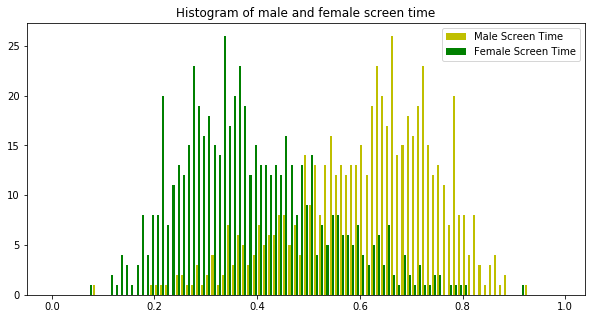

In [144]:
plot_male_female_screen_time_histograms(videos_with_gender_ratios)

In [141]:
# What about overall male/female screen time?
def plot_average_male_female_screen_time(videos_with_gender_ratios):
    male_screen_time = [np.mean([m for v, (m, f) in videos_with_gender_ratios])]
    female_screen_time = [np.mean([f for v, (m, f) in videos_with_gender_ratios])]
    
    names = ['Average Screen Time']
    N = len(names)

    ax = plt.gca()
    
    width = 0.35
    ind = np.arange(N)
    p1 = ax.bar(ind, male_screen_time, width, color='y')
    p2 = ax.bar(ind + width, female_screen_time, width, color='g')
    
    ax.set_title('Average Male/Female Screen Time')
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(names)
    ax.set_ylabel('Average Screen Time')
    ax.set_ylim((0, 1))
    
    ax.legend((p1[0], p2[0]), ('Male Screen Time', 'Female Screen Time'))
    
    def autolabel(rects):
        """
        Attach a text label above each bar displaying its height
        """
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                    '%f' % height,
                    ha='center', va='bottom')

    autolabel(p1)
    autolabel(p2)
    
    plt.show()

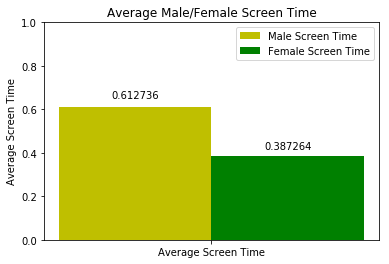

In [142]:
plot_average_male_female_screen_time(videos_with_gender_ratios)

## Changes in gender representation over time

In [139]:
# Plot male ratios by year
def plot_male_gender_ratios_by_year(videos_with_gender_ratios, min_year=None):
    data = sorted([(v.year, male_ratio) for v, (male_ratio, female_ratio) in videos_with_gender_ratios])
    if min_year is not None:
        data = [d for d in data if d[0] >= min_year]

    x = [d[0] for d in data]
    y = [d[1] for d in data]
    
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.scatter(x, y, s=3, color='y')
    ax.set_ylim(0, 1)
    ax.set_xlabel('Year')
    ax.set_ylabel('Male Screen Time Percentage')
    ax.set_title('Male Screen Time Percentage Over Time')
    
    #ax.set_yscale('symlog')
    
#     ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 3))(np.unique(x)))
    ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color='y')
    plt.show()
    
# Plot male ratios by year
def plot_female_gender_ratios_by_year(videos_with_gender_ratios, min_year=None):
    data = sorted([(v.year, female_ratio) for v, (male_ratio, female_ratio) in videos_with_gender_ratios])
    if min_year is not None:
        data = [d for d in data if d[0] >= min_year]

    x = [d[0] for d in data]
    y = [d[1] for d in data]
    
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.scatter(x, y, s=3, color='g')
    ax.set_ylim(0, 1)
    ax.set_xlabel('Year')
    ax.set_ylabel('Female Screen Time Percentage')
    ax.set_title('Female Screen Time Percentage Over Time')
    
    #ax.set_yscale('symlog')
    
#     ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 3))(np.unique(x)))
    ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color='g')
    plt.show()

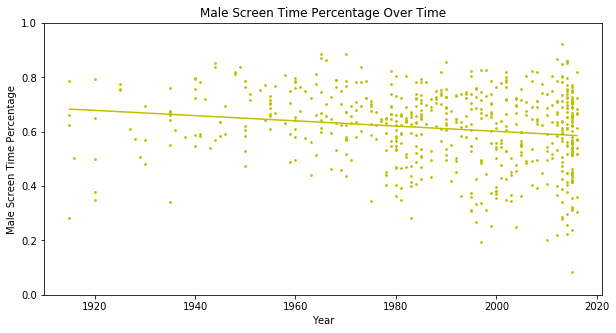

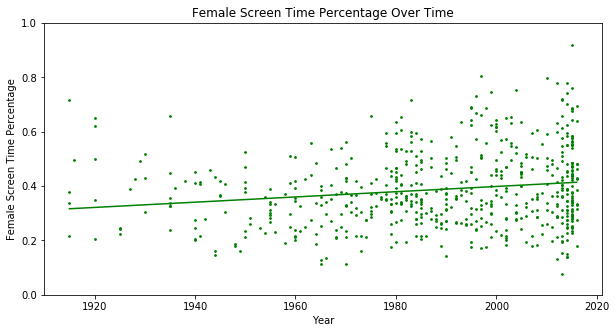

In [140]:
plot_male_gender_ratios_by_year(videos_with_gender_ratios)
plot_female_gender_ratios_by_year(videos_with_gender_ratios)

In [72]:
# What videos have exceptionally high male screen times (low female screen times)?
sorted([
    (v.title, v.year, male_screen_time)
    for v, (male_screen_time, female_screen_time) in videos_with_gender_ratios if male_screen_time > .85
], key=lambda tup: (tup[1], tup[0], tup[2]))

[('Aventure malgache', 1944, 0.8542087192623659),
 ('For a Few Dollars More', 1965, 0.870213146120759),
 ('The Flight of the Phoenix', 1965, 0.8865099484333934),
 ('The Good, the Bad and the Ugly', 1966, 0.8648148443057606),
 ('Tora! Tora! Tora!', 1970, 0.8867877494306197),
 ('The Hunt for Red October', 1990, 0.8572230514504465),
 ('Killing Them Softly', 2012, 0.8668307678183155),
 ('Locke', 2013, 0.9220389346071225),
 ('Citizenfour', 2014, 0.8512634719127781),
 ('Foxcatcher', 2014, 0.8605794933218132),
 ('The Grand Budapest Hotel', 2014, 0.8603717930002875)]

In [74]:
# What videos have exceptionally low male screen times (high female screen times)?
sorted([
    (v.title, v.year, male_screen_time)
    for v, (male_screen_time, female_screen_time) in videos_with_gender_ratios if male_screen_time < .25
], key=lambda tup: (tup[1], tup[0], tup[2]))

[("Romy and Michele's High School Reunion", 1997, 0.19488055922571174),
 ('Kill Bill: Vol. 2', 2004, 0.2481453326736492),
 ('Alice in Wonderland', 2010, 0.20287330108907933),
 ('Mental', 2012, 0.2196062060241027),
 ('Wild', 2014, 0.22245199640572594),
 ('Room', 2015, 0.08236274722511464),
 ('Sisters', 2015, 0.24012473910623172)]

## Gender Representation by Genre

We have 22 different genres. How does gender representation differ for each?

In [73]:
genres = Genre.objects.exclude(name='animation').all()

In [135]:
def plot_gender_screen_time_by_genre(videos_with_gender_ratios, genres, title):
    data = []
    for genre in genres:
        videos_in_genre = [v.id for v in Video.objects.filter(genres=genre).all()]
        male_screen_time = np.mean([m for v, (m, f) in videos_with_gender_ratios 
                                     if v.id in videos_in_genre])
        female_screen_time = np.mean([f for v, (m, f) in videos_with_gender_ratios 
                                     if v.id in videos_in_genre])
        data.append((male_screen_time, female_screen_time, genre.name))
    
    data = sorted(data)
    
    male_screen_times = [m for m, _, _ in data]
    female_screen_times = [f for _, f, _ in data]
    genres = [genre for _, _, genre in data]
    N = len(genres)

    fig, ax = plt.subplots(figsize=(10, 10))
    
    height = 0.35
    ind = np.arange(N)
    p1 = ax.barh(ind + height, male_screen_times, height, color='y')
    p2 = ax.barh(ind, female_screen_times, height, color='g')
    
    ax.set_title(title)
    ax.set_yticks(ind + height / 2)
    ax.set_yticklabels(genres)
    ax.set_xlim((0, 1))
    
    ax.legend((p1[0], p2[0]), ('Male Screen Time', 'Female Screen Time'))
    
    def autolabel(rects):
        """
        Attach a text label above each bar displaying its height
        """
        for rect in rects:
            width = rect.get_width()
            ax.text(width + .01, rect.get_y()-.2,
                    '%f Male' % width,
                    ha='left', va='bottom')

    autolabel(p1)
#     autolabel(p2)
    
    plt.show()

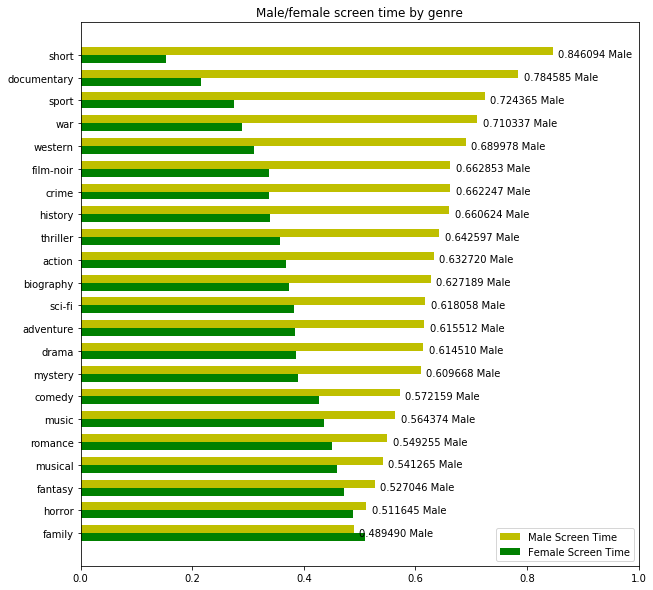

In [145]:
plot_gender_screen_time_by_genre(videos_with_gender_ratios, genres, 'Male/female screen time by genre')